# Trajectory Optimization Example 3

Similar to example 2. Construct a trajectory with multiple states (pose + velocity). Lock the first state (pose + velocity), and optimize the rest states (pose + velocity) with addtional velocity measurements at interpolated times.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib widget
np.set_printoptions(6, suppress=True)

from pylgmath import Transformation
from pysteam.trajectory import Time
from pysteam.trajectory.const_vel import Interface as TrajectoryInterface
from pysteam.problem import (
    OptimizationProblem,
    StaticNoiseModel,
    L2LossFunc,
    WeightedLeastSquareCostTerm,
)
from pysteam.solver import GaussNewtonSolver, DoglegGaussNewtonSolver
from pysteam.evaluable import vspace as vspaceev, se3 as se3ev
from pysteam.evaluable.se3 import SE3StateVar
from pysteam.evaluable.vspace import VSpaceStateVar

Set up the trajectory that uses a constant velocity motion prior:


In [4]:
# states with initial conditions and associated timestamps
NUM_STATES = 10
T_TOTAL = 1
DT = T_TOTAL / (NUM_STATES - 1)
states = [(DT * i, Transformation(), 0 * np.ones((6, 1))) for i in range(NUM_STATES)]
# states = []
# states.append((0, Transformation(), np.zeros((6, 1))))
# states.append((0.1 * T_TOTAL, Transformation(), np.array([[0.1, -0.1, 0.1, -0.1, 0.1, 0.3]]).T))
# states.append((0.3 * T_TOTAL, Transformation(), np.array([[0.3, -0.3, -0.3, 0.3, 0.6, 0.3]]).T))
# states.append((0.7 * T_TOTAL, Transformation(), np.array([[0.3, -0.3, -0.3, 0.3, 0.6, 0.3]]).T))

# wrap states with corresponding steam state variables (no copy!)
state_vars = [
    (t, SE3StateVar(T_vi), VSpaceStateVar(w_iv_inv)) for t, T_vi, w_iv_inv in states
]
state_vars[0][1].locked = True  # lock first pose
state_vars[0][2].locked = True  # lock first velocity

# construct a trajectory
qcd = np.array([0.001, 0.001, 0.001, 0.01, 0.01, 0.01])
traj = TrajectoryInterface(qcd=qcd)
for t, T_vi, w_iv_inv in state_vars:
    traj.add_knot(time=Time(t), T_k0=T_vi, w_0k_ink=w_iv_inv)

# fake velocity measurements at interpolated times
w_iv_inv_meas = []
# w_iv_inv_meas.append((0.1 * T_TOTAL, np.array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]).T))
# w_iv_inv_meas.append((0.3 * T_TOTAL, np.array([[0.3, 0.3, 0.3, 0.3, 0.3, 0.3]]).T))
w_iv_inv_meas.append((0.1 * T_TOTAL, np.array([[0.1, -0.1, 0.1, -0.1, 0.1, 0.3]]).T))
w_iv_inv_meas.append((0.3 * T_TOTAL, np.array([[0.3, -0.3, -0.3, 0.3, 0.6, 0.3]]).T))
w_iv_inv_meas.append((0.7 * T_TOTAL, np.array([[0.3, -0.3, -0.3, 0.3, 0.6, 0.3]]).T))

# velocity measurements -> cost terms
noise_model = StaticNoiseModel(np.eye(6) * 0.001)
loss_func = L2LossFunc()
cost_terms = []
for t, w in w_iv_inv_meas:
    intp_vel = traj.get_velocity_interpolator(Time(secs=t))
    error_func = vspaceev.add(VSpaceStateVar(w, locked=True), vspaceev.neg(intp_vel))
    cost_term = WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
    cost_terms.append(cost_term)

Construct the optimization problem and solve:


In [5]:
opt_prob = OptimizationProblem()
opt_prob.add_state_var(*[v for state_var in state_vars for v in state_var[1:]])
opt_prob.add_cost_term(*traj.get_prior_cost_terms())
opt_prob.add_cost_term(*cost_terms)

solver = DoglegGaussNewtonSolver(opt_prob, verbose=True)
solver.optimize()

Begin Optimization
------------------
Number of States:  18
Number of Cost Terms:  12
Initial Cost:  880.0
Iteration:    1  -  Cost:   269.2163  -  TR Shrink:  0.000  -  AvP Ratio:  0.990  -  Dogleg Segment: Gauss Newton   
Iteration:    2  -  Cost:   263.0080  -  TR Shrink:  0.000  -  AvP Ratio:  1.000  -  Dogleg Segment: Gauss Newton   
Iteration:    3  -  Cost:   263.0080  -  TR Shrink: 16.000  -  AvP Ratio:  0.318  -  Dogleg Segment: Interp GN&GD   
Termination Cause:  CONVERGED ABSOLUTE CHANGE


Print out results:


In [6]:
print("First Pose: \n", states[0][1])
print("Last Pose:  \n", states[1][1])
print("First Vel:  \n", states[0][2].squeeze())
print("Last Vel:   \n", states[1][2].squeeze())

First Pose: 
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Last Pose:  
 [[ 0.999907 -0.010846  0.008235  0.00243 ]
 [ 0.010847  0.999941 -0.000037 -0.002404]
 [-0.008234  0.000126  0.999966 -0.001477]
 [ 0.        0.        0.        1.      ]]
First Vel:  
 [0. 0. 0. 0. 0. 0.]
Last Vel:   
 [ 0.04298  -0.042962 -0.027567  0.012258  0.151779  0.181973]


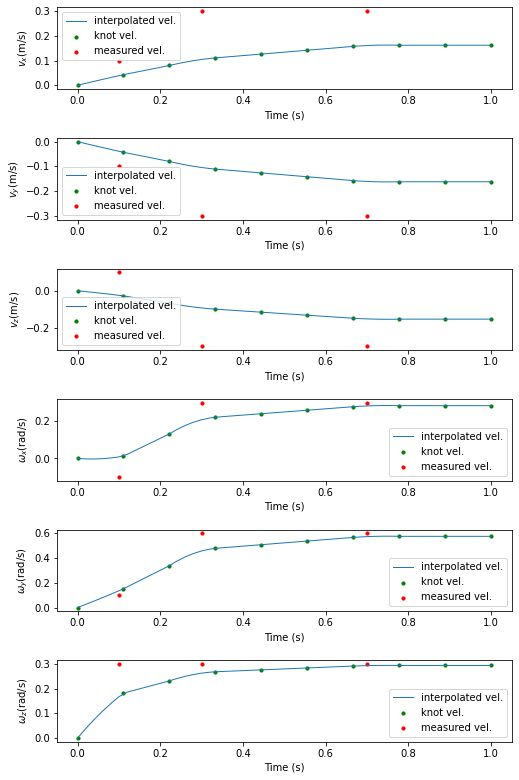

In [7]:
# knot times
knot_times = [x[0] for x in states]
knot_vels = np.array(
    [
        traj.get_velocity_interpolator(Time(secs=t)).evaluate().squeeze()
        for t in knot_times
    ]
)

# measurement values
meas_times = [x[0] for x in w_iv_inv_meas]
meas_vels = np.array([x[1].flatten() for x in w_iv_inv_meas])

# plot values
plot_times = lambda: list(np.arange(0.0, T_TOTAL, 0.02 * T_TOTAL)) + [T_TOTAL]
plot_intp_vels = np.array(
    [
        traj.get_velocity_interpolator(Time(secs=t)).evaluate().squeeze()
        for t in plot_times()
    ]
)

fig = plt.figure()

plot_number = 611
fig.set_size_inches(8, 12)
fig.subplots_adjust(left=0.16, right=0.95, bottom=0.1, top=0.95, wspace=0.7, hspace=0.6)

ylabels = [
    "$v_x$(m/s)",
    "$v_y$(m/s)",
    "$v_z$(m/s)",
    "$\omega_x$(rad/s)",
    "$\omega_y$(rad/s)",
    "$\omega_z$(rad/s)",
]
for i in range(6):
    ax = fig.add_subplot(plot_number + i)
    ax.plot(
        plot_times(),
        plot_intp_vels[:, i].squeeze(),
        "-",
        linewidth=1.0,
        label="interpolated vel.",
    )
    if len(knot_times):
        ax.scatter(
            knot_times, knot_vels[:, i].squeeze(), s=10, c="g", label="knot vel."
        )
    if len(meas_times):
        ax.scatter(
            meas_times, meas_vels[:, i].squeeze(), s=10, c="r", label="measured vel."
        )
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(ylabels[i])
    ax.legend()